# Monetary policy shocks

## Initial steps

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import io

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload() # use widget to upload your file

Saving data.csv to data.csv


In [4]:
# Import data (from Jarocinski and Karadi 2020, AEJ:Macro)
df = pd.read_csv(io.StringIO(uploaded['data.csv'].decode('utf-8')))

In [5]:
# View data

df.head()

,year,month,ff4_hf,sp500_hf,dbkeven02_d,usstocks1_hf,pc1ff1_hf,pmnegm_ff4sp500,pmposm_ff4sp500,pmnegm_pc1ff1usstocks1,pmposm_pc1ff1usstocks1,gs1,gs10,sven5f5,bkeven05,exp_gdp_12m,exp_cpi_12m,us_cpi,us_ip,logsp500,us_gdpdef,us_rgdp,ebpnew,eureon3m_hf,stoxx50_hf,deurinflswap2y_d,pmnegm_eureon3mstoxx50,pmposm_eureon3mstoxx50,ea_ip_excl_constr,hicp,stoxx50,ea_bbb_oas_all_fred,ea_rgdp,ea_gdpdef,de1y_haver
0,1979,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.640000,8.95,8.519385,NaN,NaN,NaN,429.04593,397.93228,463.16483,371.07132,877.20264,-0.2544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.979999,9.03,8.595396,NaN,NaN,NaN,430.00027,397.25439,467.60703,371.73209,875.45850,-0.3394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1979,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.840000,9.33,8.779437,NaN,NaN,NaN,430.94559,397.36560,468.79752,372.46835,874.66516,-0.1530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1979,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.440000,10.30,9.505091,NaN,NaN,NaN,432.01514,397.89655,464.89291,373.16437,876.48096,-0.7801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1979,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.390000,10.65,9.933131,NaN,NaN,NaN,433.07333,397.79791,464.12521,373.72144,875.74719,-0.1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like we have a lot of NAs and a lot of unnecessary columns - let's remove them.
The columns we want are 'year', 'month', 'ff4_hf', 'sp500_hf', 'logsp500', 'gs1', 'us_rgdp', 'us_gdpdef'. Most of these names are self explanatory. Others aren't: ff4_hf is the high frequency surprise in fed funds futures, sp500_hf is the high frequency surprise in the stock market, gs1 is a short term interest rate measure.

In [6]:
# Wrangle data: remove unnecessary columns

column_list = ['year', 'month', 'ff4_hf', 'sp500_hf', 'logsp500', 'gs1', 'us_rgdp', 'us_gdpdef'] # these are the columns we want to keep
df = df.loc[:, column_list]

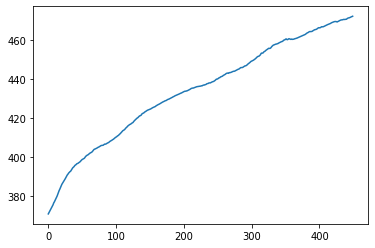

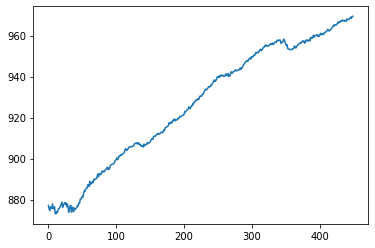

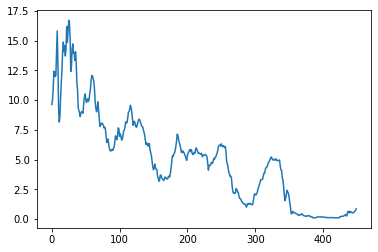

In [7]:
# Plot the data

plt.plot(df.us_gdpdef)
plt.show()

plt.plot(df.us_rgdp)
plt.show()

plt.plot(df.gs1)
plt.show()

Whats the problem with the first two graphs? If we think the data is non-stationary, we should alter it for our VARs.

In the cell below:
1. Decide if you want to transform the data, and if so, how. (Hint: consult documentation on pandas.series.diff)
2. Restrict the dataframe to just the (transformed) cpi, ip and ff4_hf, and call the new dataframe df_data
3. Drop any rows that contain NAs from the dataframe (Hint: consult documentation on pandas.dropna)

In [8]:
# -- #

df.loc[:, 'us_rgdp_diff'] = df.loc[:, 'us_rgdp'].diff(periods=1)
df.loc[:, 'us_gdpdef_diff'] = df.loc[:, 'us_gdpdef'].diff(periods=1)


df_data = df.loc[:, ['us_gdpdef_diff', 'us_rgdp_diff', 'ff4_hf']]
df_data.dropna(axis=0, inplace=True) # remove any NAs

## VARs

In [9]:
# Run a VAR
model = VAR(df_data)
results = model.fit(4) # 4 is the number of lags we use

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [10]:
# Print a summary of the results
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Sep, 2021
Time:                     11:25:43
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.0844
Nobs:                     319.000    HQIC:                  -11.3609
Log likelihood:           522.466    FPE:                9.68795e-06
AIC:                     -11.5448    Det(Omega_mle):     8.59389e-06
--------------------------------------------------------------------
Results for equation us_gdpdef_diff
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.065017         0.015266            4.259           0.000
L1.us_gdpdef_diff         0.372450         0.056088            6.640           0.000
L1.us_rgdp_diff           0.029573 

In [11]:
# Create irfs
irf = results.irf(20)

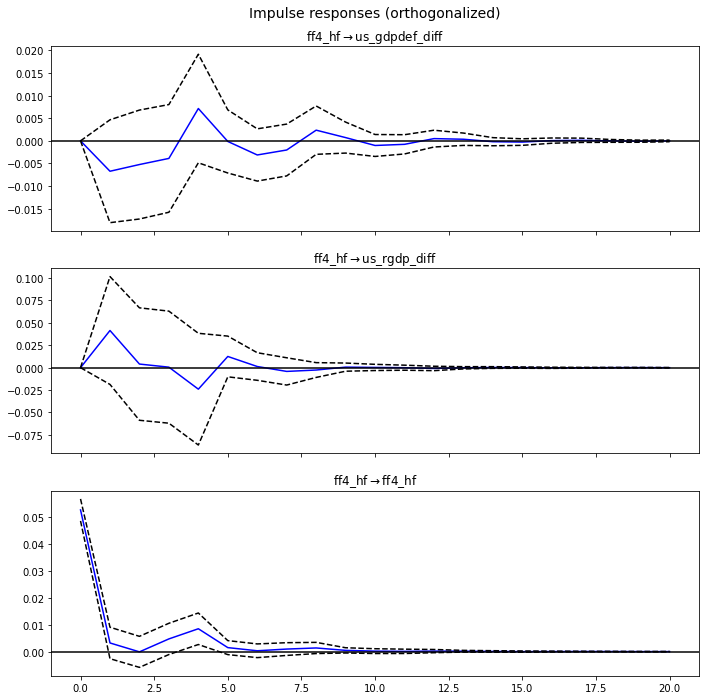

In [12]:
# Plot irfs
plot = irf.plot(orth=True, impulse='ff4_hf')

Now you know how to run a basic VAR in python. In the cells below:
1. Add controls to your dataframe, including the surprises in the S&P500, the measure of interest rates gs1, the US real GDP, US GDP deflator, and log S&P 500. Remember to transform data appropriately if you think it is non-stationary
2. Run a VAR with the surprises ordered first, followed by gs1, followed by the S&P500, followed by real GDP, and finally the US GDP deflator (why would this ordering be sensible? What does it imply about the information set of the central bank. This is what J&K use)

In [13]:
# Add more controls

df.loc[:, 'logsp500_diff'] = df.loc[:, 'logsp500'].diff(periods=1)

df_data = df.loc[:, ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500_diff', 'us_rgdp_diff', 'us_gdpdef_diff']].copy()
df_data.dropna(axis=0, inplace=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


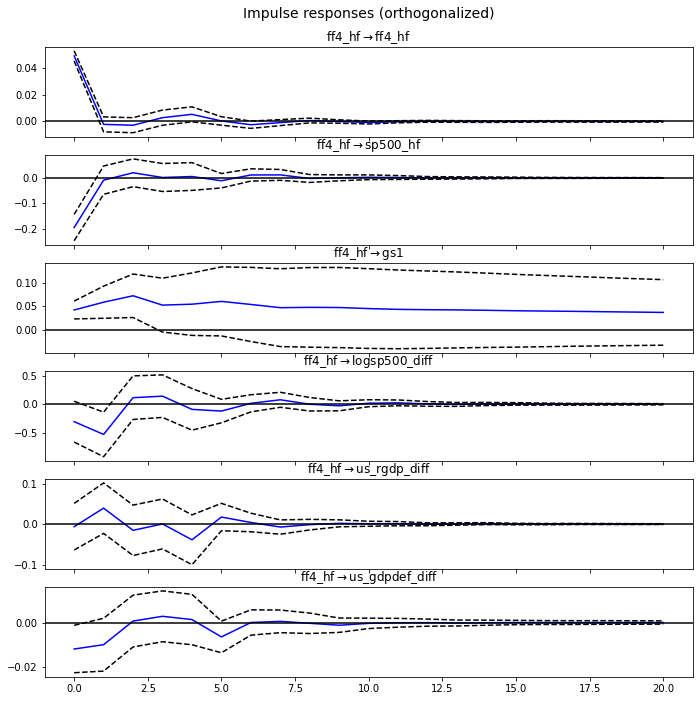

In [14]:
# Run VAR
model = VAR(df_data)
results=model.fit(4)
irf = results.irf(20)
plot = irf.plot(orth=True, impulse='ff4_hf')

This should now look pretty similar to Jarocinksi and Karadi's VAR in Panel B of page 13. It won't be exactly the same as we have (i) not imposed the exact restrictions they have on the HF shocks, (ii) not included all of the controls, and (iii) depending on how we removed stationarity may have slightly different variables - indeed they leave the variables in log-levels.

There's not much going on in this VAR - which is why JK use sign-restrictions to try to get at monetary policy shocks versus information shocks. After doing that they find results more in line with what theory would predict.

Now: In the cells below, run a VAR with the ordering reversed (this is a more standard ordering - why?)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


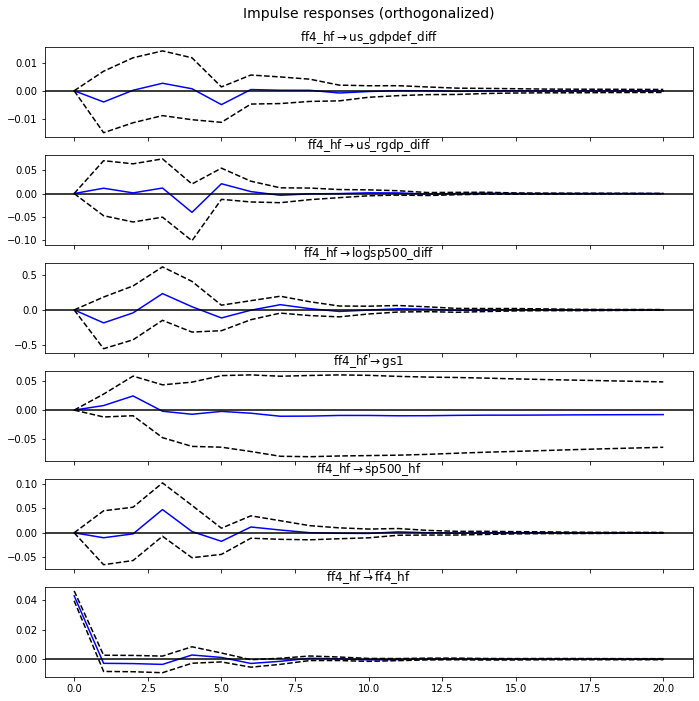

In [15]:
# -- #
my_list = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500_diff', 'us_rgdp_diff', 'us_gdpdef_diff']
my_list.reverse()
df_data = df.loc[:, my_list]
df_data.dropna(axis=0, inplace=True)
model = VAR(df_data)
results=model.fit(4)
irf = results.irf(20)
plot = irf.plot(orth=True, impulse='ff4_hf')

There was at one point a 'price puzzle' in VARs, in which interest rates looked like they increased inflation. This puzzle occured a while ago. Let's see if we can find it in the data. 

In the cells below:
Run a three variable VAR of gs1, us_rgdp, us_gdpdef, all untransformed (i.e. estimated in log levels), and with interest rates ordered first. But - restrict the VAR to data occuring to 2000 and before...

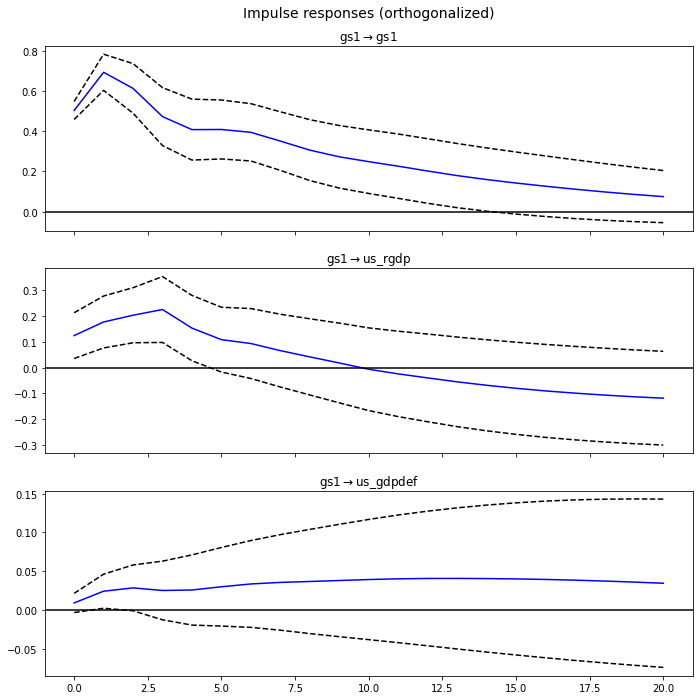

In [16]:
# Restricted VAR to old data to see price puzzle
df_data_old = df.loc[:, ['gs1', 'us_rgdp', 'us_gdpdef']]
df_data_old = df_data_old.iloc[:df.loc[df.loc[:, 'year']==2000, :].index[0], :] # get data up to 2000
df_data_old.dropna(axis=0, inplace=True)
model = VAR(df_data_old)
results=model.fit(4)
irf = results.irf(20)
plot = irf.plot(orth=True, impulse='gs1')

## Local projections

In the lectures you will have seen what local projections are. In the cells below
1. Create a dataframe containing ff4_hf, us_rgdp (transformed however), and sp500_hf
2. Run local projections to create an "impulse responses" of length 20 of the effect of ff4_hf on US real GDP, including confidence intervals (Hint: you will need a for loop, and sm.OLS() to run OLS regressions)
3. Then run a VAR with the same variables and check that the (qualitative) answers are similar

In [ ]:
# Create dataframe to use for local projections

df_lp = df.loc[:, ['ff4_hf', 'us_rgdp_diff', 'sp500_hf']]
df_lp.dropna(inplace=True)

In [ ]:
# Run local projections
irf_length = 20
coeff_array = np.zeros(irf_length)
stderr_array = np.zeros(irf_length)

for i in np.arange(irf_length):
    X = df_lp.loc[:, 'ff4_hf']
    X = sm.add_constant(X, prepend=True)
    X['lag'] = df_lp.loc[:, 'us_rgdp_diff'].copy().shift(1)
    y = df_lp.loc[:, 'us_rgdp_diff'].copy().shift(-i+1)
    model = sm.OLS(y, X, missing='drop')
    res = model.fit()
    coeff_array[i] = res.params[1]
    stderr_array[i] = res.bse[1]


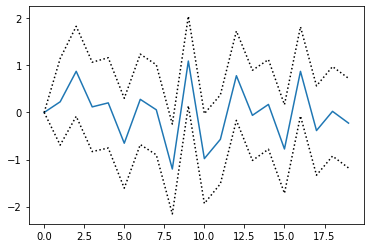

In [ ]:
# Plot
plt.plot(np.arange(irf_length), coeff_array)
plt.plot(np.arange(irf_length), coeff_array + 1.64*stderr_array, 'k:')
plt.plot(np.arange(irf_length), coeff_array - 1.64*stderr_array, 'k:')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


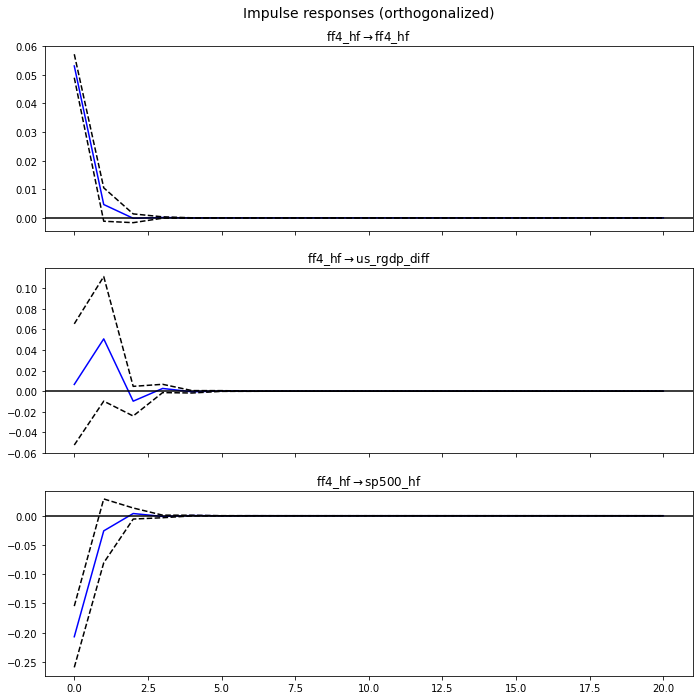

In [ ]:
# Check that the VAR gives similar results
model = VAR(df_lp)
results=model.fit(1)
irf = results.irf(20)
plot = irf.plot(orth=True, impulse='ff4_hf')